# **Quick PyTorch 2.0**

## **Getting Setup**

In [1]:
# Import
import torch

# Check PyTorch version
pt_version = torch.__version__
print(f"[INFO] Current PyTorch version: {pt_version} (should be 2.x+)")

# Install PyTorch 2.0 if necessary
if pt_version.split(".")[0] == "1": # Check if PyTorch version begins with 1
    !pip3 install torch torchvision torchaudio --quiet
    print("[INFO] PyTorch 2.x installed, if you're on Google Colab, you may need to restart your runtime.\
          Though as of April 2023, Google Colab comes with PyTorch 2.0 pre-installed.")
    import torch
    pt_version = torch.__version__
    print(f"[INFO] Current PyTorch version: {pt_version} (should be 2.x+)")
else:
    print("[INFO] PyTorch 2.x installed, you'll be able to use the new features.")

[INFO] Current PyTorch version: 2.0.1+cu118 (should be 2.x+)
[INFO] PyTorch 2.x installed, you'll be able to use the new features.


## **Getting GPU Info**

In [2]:
# Make sure we're using a NVIDIA GPU
if torch.cuda.is_available():
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find("failed") >= 0:
        print("Not connected to a GPU, to leverage the best of PyTorch 2.0, you should connect to a GPU.")

    # Get GPU name
    gpu_name = !nvidia-smi --query-gpu=gpu_name --format=csv
    gpu_name = gpu_name[1]
    GPU_NAME = gpu_name.replace(" ", "_") # remove underscores for easier saving
    print(f'GPU name: {GPU_NAME}')

    # Get GPU capability score
    GPU_SCORE = torch.cuda.get_device_capability()
    print(f"GPU capability score: {GPU_SCORE}")
    if GPU_SCORE >= (8, 0):
        print(f"GPU score higher than or equal to (8, 0), PyTorch 2.x speedup features available.")
    else:
        print(f"GPU score lower than (8, 0), PyTorch 2.x speedup features will be limited (PyTorch 2.x speedups happen most on newer GPUs).")

    # Print GPU info
    print(f"GPU information:\n{gpu_info}")

else:
    print("PyTorch couldn't find a GPU, to leverage the best of PyTorch 2.0, you should connect to a GPU.")

GPU name: Tesla_T4
GPU capability score: (7, 5)
GPU score lower than (8, 0), PyTorch 2.x speedup features will be limited (PyTorch 2.x speedups happen most on newer GPUs).
GPU information:
Tue Jul 25 19:08:56 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |   

### **Globally Set Devices**

In [3]:
# Import
import torch

# Set the device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Set the device with context manager (requires PyTorch 2.x+)
with torch.device(device):
    # All tensors created in this block will be on device
    layer = torch.nn.Linear(20, 30)
    print(f"Layer weights are on device: {layer.weight.device}")
    print(f"Layer creating data on device: {layer(torch.randn(128, 20)).device}")

Layer weights are on device: cuda:0
Layer creating data on device: cuda:0


## **Setting Up Experiment**

### **Device Agnostic Setting**

In [4]:
# Import
import torch
import torchvision

# Print torch version
print(f"PyTorch version: {torch.__version__}")
print(f"TorchVision version: {torchvision.__version__}")

# Set the target device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Print the device
print(f"Using device: {device}")

PyTorch version: 2.0.1+cu118
TorchVision version: 0.15.2+cu118
Using device: cuda


### **Model and Transforms**

In [5]:
# Create model weights and transforms
model_weights = torchvision.models.ResNet50_Weights.IMAGENET1K_V2
transforms = model_weights.transforms()

# Setup model
model = torchvision.models.resnet50(weights = model_weights)

# Count the number of parameters in the model
total_params = sum(
    param.numel() for param in model.parameters()
)

# Print the parameter count
print(f"Total parameters of model: {total_params} (the more parameters, the more GPU memory the model will use, the more *relative* of a speedup you'll get)")
print(f"Model transforms:\n{transforms}")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 88.6MB/s]


Total parameters of model: 25557032 (the more parameters, the more GPU memory the model will use, the more *relative* of a speedup you'll get)
Model transforms:
ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [6]:
# Function to create the model
def create_model(num_classes = 10):
    # Model weights, transforms and models
    model_weights = torchvision.models.ResNet50_Weights.IMAGENET1K_V2
    transforms = model_weights.transforms()
    model = torchvision.models.resnet50(weights=model_weights)

    # Adjust the number of output features in model to match the number of classes in the dataset
    model.fc = torch.nn.Linear(
        in_features = 2048,
        out_features = num_classes
    )

    # Return the model and transforms
    return model, transforms

# Call the function and get the model and transforms
model, transforms = create_model()

### **Checking Memory Limit**

In [7]:
# Check available GPU memory and total GPU memory
total_free_gpu_memory, total_gpu_memory = torch.cuda.mem_get_info()
print(f"Total free GPU memory: {round(total_free_gpu_memory * 1e-9, 3)} GB")
print(f"Total GPU memory: {round(total_gpu_memory * 1e-9, 3)} GB")

Total free GPU memory: 14.983 GB
Total GPU memory: 15.835 GB


In [8]:
# Set batch size depending on amount of GPU memory
total_free_gpu_memory_gb = round(total_free_gpu_memory * 1e-9, 3)
if total_free_gpu_memory_gb >= 16:
    BATCH_SIZE = 128 # Note: you could experiment with higher values here if you like.
    IMAGE_SIZE = 224
    print(f"GPU memory available is {total_free_gpu_memory_gb} GB, using batch size of {BATCH_SIZE} and image size {IMAGE_SIZE}")
else:
    BATCH_SIZE = 32
    IMAGE_SIZE = 128
    print(f"GPU memory available is {total_free_gpu_memory_gb} GB, using batch size of {BATCH_SIZE} and image size {IMAGE_SIZE}")

GPU memory available is 14.983 GB, using batch size of 32 and image size 128


In [9]:
# Get the updated transforms
transforms.crop_size = IMAGE_SIZE
transforms.resize_size = IMAGE_SIZE
print(f"Updated data transforms:\n{transforms}")

Updated data transforms:
ImageClassification(
    crop_size=128
    resize_size=128
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


### **Potential Speedups with TF32**

In [10]:
if GPU_SCORE >= (8, 0):
    print(f"[INFO] Using GPU with score: {GPU_SCORE}, enabling TensorFloat32 (TF32) computing (faster on new GPUs)")
    torch.backends.cuda.matmul.allow_tf32 = True
else:
    print(f"[INFO] Using GPU with score: {GPU_SCORE}, TensorFloat32 (TF32) not available, to use it you need a GPU with score >= (8, 0)")
    torch.backends.cuda.matmul.allow_tf32 = False

[INFO] Using GPU with score: (7, 5), TensorFloat32 (TF32) not available, to use it you need a GPU with score >= (8, 0)


### **Preparing Dataset**

In [11]:
# Create train and test datasets
train_dataset = torchvision.datasets.CIFAR10(
    root = '.',
    train = True,
    download = True,
    transform = transforms
)

test_dataset = torchvision.datasets.CIFAR10(
    root = '.',
    train = False,
    download = True,
    transform = transforms
)

# Get the lengths of the datasets
train_len = len(train_dataset)
test_len = len(test_dataset)

print(f"[INFO] Train dataset length: {train_len}")
print(f"[INFO] Test dataset length: {test_len}")

100%|██████████| 170498071/170498071 [00:05<00:00, 28722337.33it/s]


Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified
[INFO] Train dataset length: 50000
[INFO] Test dataset length: 10000


### **Create DataLoaders**

In [12]:
# Import
from torch.utils.data import DataLoader

# Create DataLoaders
import os
NUM_WORKERS = os.cpu_count() # <- use all available CPU cores

train_dataloader = DataLoader(
    dataset = train_dataset,
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers = NUM_WORKERS
)

test_dataloader = DataLoader(
    dataset = test_dataset,
    batch_size = BATCH_SIZE,
    shuffle = False,
    num_workers = NUM_WORKERS
)

# Print details
print(f"Train dataloader length: {len(train_dataloader)} batches of size {BATCH_SIZE}")
print(f"Test dataloader length: {len(test_dataloader)} batches of size {BATCH_SIZE}")
print(f"Using number of workers: {NUM_WORKERS} (generally more workers means faster dataloading from CPU to GPU)")

Train dataloader length: 1563 batches of size 32
Test dataloader length: 313 batches of size 32
Using number of workers: 2 (generally more workers means faster dataloading from CPU to GPU)


In [13]:
# Import
import time
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(epoch: int,
               model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device,
               disable_progress_bar: bool = False) -> Tuple[float, float]:
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    progress_bar = tqdm(
        enumerate(dataloader),
        desc = f"Training Epoch {epoch}",
        total = len(dataloader),
        disable = disable_progress_bar
    )

    for batch, (X, y) in progress_bar:
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim = 1), dim = 1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)

        # Update progress bar
        progress_bar.set_postfix(
            {
                "train_loss": train_loss / (batch + 1),
                "train_acc": train_acc / (batch + 1),
            }
        )


    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(epoch: int,
              model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device,
              disable_progress_bar: bool = False) -> Tuple[float, float]:

    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Loop through data loader data batches
    progress_bar = tqdm(
        enumerate(dataloader),
        desc = f"Testing Epoch {epoch}",
        total = len(dataloader),
        disable = disable_progress_bar
    )

    # Turn on inference context manager
    with torch.no_grad(): # no_grad() required for PyTorch 2.0, I found some errors with `torch.inference_mode()`, please let me know if this is not the case
        # Loop through DataLoader batches
        for batch, (X, y) in progress_bar:
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim = 1)
            test_acc += ((test_pred_labels == y).sum().item() / len(test_pred_labels))

            # Update progress bar
            progress_bar.set_postfix(
                {
                    "test_loss": test_loss / (batch + 1),
                    "test_acc": test_acc / (batch + 1),
                }
            )

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          disable_progress_bar: bool = False) -> Dict[str, List]:
    # Create empty results dictionary
    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": [],
        "train_epoch_time": [],
        "test_epoch_time": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs), disable=disable_progress_bar):

        # Perform training step and time it
        train_epoch_start_time = time.time()
        train_loss, train_acc = train_step(
            epoch = epoch,
            model = model,
            dataloader = train_dataloader,
            loss_fn = loss_fn,
            optimizer = optimizer,
            device = device,
            disable_progress_bar = disable_progress_bar
        )
        train_epoch_end_time = time.time()
        train_epoch_time = train_epoch_end_time - train_epoch_start_time

        # Perform testing step and time it
        test_epoch_start_time = time.time()
        test_loss, test_acc = test_step(
            epoch = epoch,
            model = model,
            dataloader = test_dataloader,
            loss_fn = loss_fn,
            device = device,
            disable_progress_bar = disable_progress_bar
        )
        test_epoch_end_time = time.time()
        test_epoch_time = test_epoch_end_time - test_epoch_start_time

        # Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f} | "
            f"train_epoch_time: {train_epoch_time:.4f} | "
            f"test_epoch_time: {test_epoch_time:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        results["train_epoch_time"].append(train_epoch_time)
        results["test_epoch_time"].append(test_epoch_time)

    # Return the filled results at the end of the epochs
    return results

## **Time Models Across Single Run**

### **Experiment 1 - Single Run - No Compile**

In [14]:
# Set the number of epochs as a constant
NUM_EPOCHS = 5

# Set the learning rate as a constant
LEARNING_RATE = 0.003

In [15]:
# Create model
model, transforms = create_model()
model.to(device)

# Create loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr = LEARNING_RATE
)

# Train model and track results
single_run_no_compile_results = train(
    model = model,
    train_dataloader = train_dataloader,
    test_dataloader = test_dataloader,
    loss_fn = loss_fn,
    optimizer = optimizer,
    epochs = NUM_EPOCHS,
    device = device
)

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0817 | train_acc: 0.6147 | test_loss: 0.8063 | test_acc: 0.7199 | train_epoch_time: 202.3451 | test_epoch_time: 15.9998


Training Epoch 1:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 0.6509 | train_acc: 0.7742 | test_loss: 0.6755 | test_acc: 0.7693 | train_epoch_time: 200.2130 | test_epoch_time: 14.8258


Training Epoch 2:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 0.5010 | train_acc: 0.8279 | test_loss: 0.5742 | test_acc: 0.8055 | train_epoch_time: 200.2664 | test_epoch_time: 14.8115


Training Epoch 3:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 0.4010 | train_acc: 0.8607 | test_loss: 0.4798 | test_acc: 0.8354 | train_epoch_time: 199.8551 | test_epoch_time: 15.0378


Training Epoch 4:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 0.3156 | train_acc: 0.8908 | test_loss: 0.4961 | test_acc: 0.8332 | train_epoch_time: 200.3286 | test_epoch_time: 15.5275


### **Experiment 2 - Single Run - With Compile**

In [16]:
# Create model and transforms
model, transforms = create_model()
model.to(device)

# Create loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr = LEARNING_RATE
)

# Compile the model and time how long it takes
compile_start_time = time.time()

### New in PyTorch 2.x ###
compiled_model = torch.compile(model)
##########################

compile_end_time = time.time()
compile_time = compile_end_time - compile_start_time
print(f"Time to compile: {compile_time} | Note: The first time you compile your model, the first few epochs will be slower than subsequent runs.")

# Train the compiled model
single_run_compile_results = train(
    model = compiled_model,
    train_dataloader = train_dataloader,
    test_dataloader = test_dataloader,
    loss_fn = loss_fn,
    optimizer = optimizer,
    epochs = NUM_EPOCHS,
    device = device
)

Time to compile: 0.2825028896331787 | Note: The first time you compile your model, the first few epochs will be slower than subsequent runs.


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1341 | train_acc: 0.5944 | test_loss: 0.8891 | test_acc: 0.6918 | train_epoch_time: 286.0522 | test_epoch_time: 41.0043


Training Epoch 1:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 0.6859 | train_acc: 0.7612 | test_loss: 0.6852 | test_acc: 0.7628 | train_epoch_time: 196.9530 | test_epoch_time: 14.8066


Training Epoch 2:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 0.5160 | train_acc: 0.8216 | test_loss: 0.5593 | test_acc: 0.8041 | train_epoch_time: 196.4684 | test_epoch_time: 14.8887


Training Epoch 3:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 0.4090 | train_acc: 0.8584 | test_loss: 0.5410 | test_acc: 0.8193 | train_epoch_time: 197.1511 | test_epoch_time: 14.3192


Training Epoch 4:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 0.3218 | train_acc: 0.8876 | test_loss: 0.4791 | test_acc: 0.8429 | train_epoch_time: 196.5808 | test_epoch_time: 14.0475


### **Compare Results of Experiment 1 and 2**

In [17]:
# Turn experiment results into dataframes
import pandas as pd
single_run_no_compile_results_df = pd.DataFrame(single_run_no_compile_results)
single_run_compile_results_df = pd.DataFrame(single_run_compile_results)

In [18]:
# Check out the head of one of the results dataframes
single_run_no_compile_results_df.head()

,train_loss,train_acc,test_loss,test_acc,train_epoch_time,test_epoch_time
0,1.081712,0.614683,0.806338,0.719948,202.345142,15.999789
1,0.650864,0.774212,0.675531,0.769269,200.213014,14.825781
2,0.501033,0.827895,0.574211,0.805511,200.266361,14.811538
3,0.401002,0.860725,0.479848,0.835363,199.855054,15.037798
4,0.315644,0.890835,0.496095,0.833167,200.328594,15.527520


In [19]:
# Create filename to save the results
DATASET_NAME = "CIFAR10"
MODEL_NAME = "ResNet50"

In [20]:
# Imports
import matplotlib.pyplot as plt
import numpy as np

# Function
def plot_mean_epoch_times(non_compiled_results: pd.DataFrame,
                          compiled_results: pd.DataFrame,
                          multi_runs: bool = False,
                          num_runs: int = 0,
                          save: bool = False,
                          save_path: str = "",
                          dataset_name: str = DATASET_NAME,
                          model_name: str = MODEL_NAME,
                          num_epochs: int = NUM_EPOCHS,
                          image_size: int = IMAGE_SIZE,
                          batch_size: int = BATCH_SIZE) -> plt.figure:

    # Get the mean epoch times from the non-compiled models
    mean_train_epoch_time = non_compiled_results.train_epoch_time.mean()
    mean_test_epoch_time = non_compiled_results.test_epoch_time.mean()
    mean_results = [mean_train_epoch_time, mean_test_epoch_time]

    # Get the mean epoch times from the compiled models
    mean_compile_train_epoch_time = compiled_results.train_epoch_time.mean()
    mean_compile_test_epoch_time = compiled_results.test_epoch_time.mean()
    mean_compile_results = [mean_compile_train_epoch_time, mean_compile_test_epoch_time]

    # Calculate the percentage difference between the mean compile and non-compile train epoch times
    train_epoch_time_diff = mean_compile_train_epoch_time - mean_train_epoch_time
    train_epoch_time_diff_percent = (train_epoch_time_diff / mean_train_epoch_time) * 100

    # Calculate the percentage difference between the mean compile and non-compile test epoch times
    test_epoch_time_diff = mean_compile_test_epoch_time - mean_test_epoch_time
    test_epoch_time_diff_percent = (test_epoch_time_diff / mean_test_epoch_time) * 100

    # Print the mean difference percentages
    print(f"Mean train epoch time difference: {round(train_epoch_time_diff_percent, 3)}% (negative means faster)")
    print(f"Mean test epoch time difference: {round(test_epoch_time_diff_percent, 3)}% (negative means faster)")

    # Create a bar plot of the mean train and test epoch time for both compiled and non-compiled models
    plt.figure(figsize=(10, 7))
    width = 0.3
    x_indicies = np.arange(len(mean_results))

    plt.bar(x = x_indicies, height = mean_results, width = width, label = "non_compiled_results")
    plt.bar(x = x_indicies + width, height = mean_compile_results, width = width, label = "compiled_results")
    plt.xticks(x_indicies + width / 2, ("Train Epoch", "Test Epoch"))
    plt.ylabel("Mean epoch time (seconds, lower is better)")

    # Create the title based on the parameters passed to the function
    if multi_runs:
        plt.suptitle("Multiple run results")
        plt.title(f"GPU: {gpu_name} | Epochs: {num_epochs} ({num_runs} runs) | Data: {dataset_name} | Model: {model_name} | Image size: {image_size} | Batch size: {batch_size}")
    else:
        plt.suptitle("Single run results")
        plt.title(f"GPU: {gpu_name} | Epochs: {num_epochs} | Data: {dataset_name} | Model: {model_name} | Image size: {image_size} | Batch size: {batch_size}")
    plt.legend();

    # Save the figure
    if save:
        assert save_path != "", "Please specify a save path to save the model figure to via the save_path parameter."
        plt.savefig(save_path)
        print(f"[INFO] Plot saved to {save_path}")

[INFO] Save path for single run results: pytorch_2_results/figures/single_run_Tesla_T4_ResNet50_CIFAR10_128_train_epoch_time.png
Mean train epoch time difference: 6.999% (negative means faster)
Mean test epoch time difference: 30.004% (negative means faster)
[INFO] Plot saved to pytorch_2_results/figures/single_run_Tesla_T4_ResNet50_CIFAR10_128_train_epoch_time.png


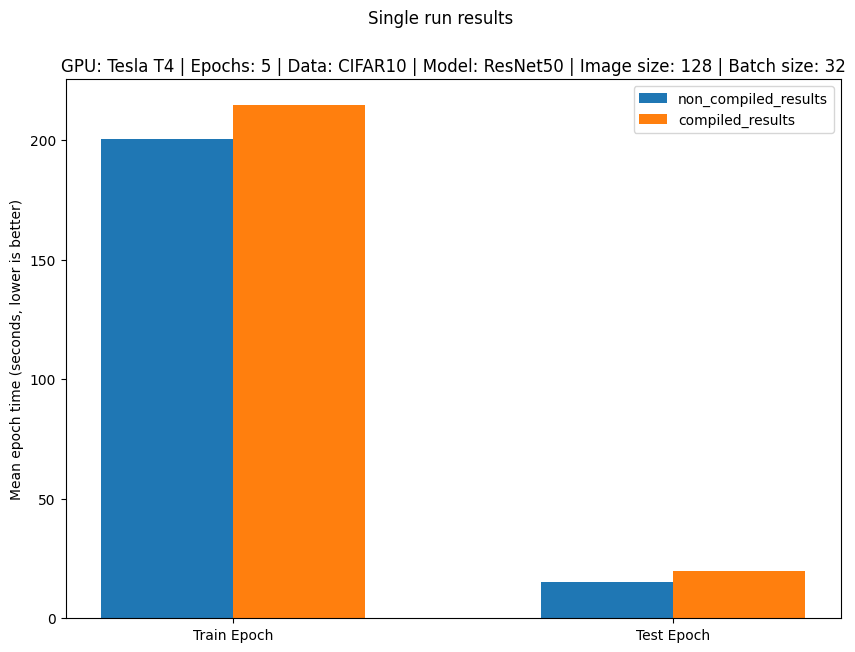

In [21]:
# Create directory for saving figures
import os
dir_to_save_figures_in = "pytorch_2_results/figures/"
os.makedirs(dir_to_save_figures_in, exist_ok=True)

# Create a save path for the single run results
save_path_multi_run = f"{dir_to_save_figures_in}single_run_{GPU_NAME}_{MODEL_NAME}_{DATASET_NAME}_{IMAGE_SIZE}_train_epoch_time.png"
print(f"[INFO] Save path for single run results: {save_path_multi_run}")

# Plot the results and save the figures
plot_mean_epoch_times(
    non_compiled_results = single_run_no_compile_results_df,
    compiled_results = single_run_compile_results_df,
    multi_runs = False,
    save_path = save_path_multi_run,
    save = True
)

In [22]:
# Make a directory for single_run results
import os
pytorch_2_results_dir = "pytorch_2_results"
pytorch_2_single_run_results_dir = f"{pytorch_2_results_dir}/single_run_results"
os.makedirs(pytorch_2_single_run_results_dir, exist_ok=True)

# Create filenames for each of the dataframes
save_name_for_non_compiled_results = f"single_run_non_compiled_results_{DATASET_NAME}_{MODEL_NAME}_{GPU_NAME}.csv"
save_name_for_compiled_results = f"single_run_compiled_results_{DATASET_NAME}_{MODEL_NAME}_{GPU_NAME}.csv"

# Create filepaths to save the results to
single_run_no_compile_save_path = f"{pytorch_2_single_run_results_dir}/{save_name_for_non_compiled_results}"
single_run_compile_save_path = f"{pytorch_2_single_run_results_dir}/{save_name_for_compiled_results}"
print(f"[INFO] Saving non-compiled experiment 1 results to: {single_run_no_compile_save_path}")
print(f"[INFO] Saving compiled experiment 2 results to: {single_run_compile_save_path}")

# Save the results
single_run_no_compile_results_df.to_csv(single_run_no_compile_save_path)
single_run_compile_results_df.to_csv(single_run_compile_save_path)

[INFO] Saving non-compiled experiment 1 results to: pytorch_2_results/single_run_results/single_run_non_compiled_results_CIFAR10_ResNet50_Tesla_T4.csv
[INFO] Saving compiled experiment 2 results to: pytorch_2_results/single_run_results/single_run_compiled_results_CIFAR10_ResNet50_Tesla_T4.csv


In [23]:
# Function to create and train a non compiled model
def create_and_train_non_compiled_model(epochs = NUM_EPOCHS,
                                        learning_rate = LEARNING_RATE,
                                        disable_progress_bar = False):
    model, _ = create_model()
    model.to(device)

    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr = learning_rate
    )

    results = train(
        model = model,
        train_dataloader = train_dataloader,
        test_dataloader = test_dataloader,
        loss_fn = loss_fn,
        optimizer = optimizer,
        epochs = epochs,
        device = device,
        disable_progress_bar = disable_progress_bar
    )
    return results

# Function to create a compiled model
def create_compiled_model():
    """
    Create a compiled PyTorch model and return it.
    """
    model, _ = create_model()
    model.to(device)

    compile_start_time = time.time()
    ### New in PyTorch 2.x ###
    compiled_model = torch.compile(model)
    ##########################
    compile_end_time = time.time()

    compile_time = compile_end_time - compile_start_time

    print(f"Time to compile: {compile_time} | Note: The first time you compile your model, the first few epochs will be slower than subsequent runs.")
    return compiled_model

# Function to train compiled model
def train_compiled_model(model = compiled_model,
                         epochs = NUM_EPOCHS,
                         learning_rate = LEARNING_RATE,
                         disable_progress_bar = False):
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(
        compiled_model.parameters(),
        lr = learning_rate
    )

    compile_results = train(
        model = model,
        train_dataloader = train_dataloader,
        test_dataloader = test_dataloader,
        loss_fn = loss_fn,
        optimizer = optimizer,
        epochs = epochs,
        device = device,
        disable_progress_bar = disable_progress_bar
    )

    return compile_results

## **Time Models Across Single Run**

### **Experiment 3 - Multiple Run - Non Compile**

In [24]:
# Run non-compiled model for multiple runs
NUM_RUNS = 3
NUM_EPOCHS = 5

# Create an empty list to store multiple run results
non_compile_results_multiple_runs = []

# Run non-compiled model for multiple runs
for i in tqdm(range(NUM_RUNS)):
    print(f"[INFO] Run {i+1} of {NUM_RUNS} for non-compiled model")
    results = create_and_train_non_compiled_model(epochs = NUM_EPOCHS, disable_progress_bar = True)
    non_compile_results_multiple_runs.append(results)

  0%|          | 0/3 [00:00<?, ?it/s]

[INFO] Run 1 of 3 for non-compiled model
Epoch: 1 | train_loss: 1.1196 | train_acc: 0.6017 | test_loss: 0.9174 | test_acc: 0.6885 | train_epoch_time: 193.4805 | test_epoch_time: 13.7035
Epoch: 2 | train_loss: 0.6835 | train_acc: 0.7651 | test_loss: 0.7340 | test_acc: 0.7373 | train_epoch_time: 193.3099 | test_epoch_time: 13.6854
Epoch: 3 | train_loss: 0.5250 | train_acc: 0.8184 | test_loss: 0.5565 | test_acc: 0.8106 | train_epoch_time: 193.3626 | test_epoch_time: 13.7354
Epoch: 4 | train_loss: 0.4157 | train_acc: 0.8559 | test_loss: 0.4950 | test_acc: 0.8296 | train_epoch_time: 193.2248 | test_epoch_time: 13.4941
Epoch: 5 | train_loss: 0.3262 | train_acc: 0.8864 | test_loss: 0.5088 | test_acc: 0.8332 | train_epoch_time: 193.3211 | test_epoch_time: 13.6003
[INFO] Run 2 of 3 for non-compiled model
Epoch: 1 | train_loss: 1.1505 | train_acc: 0.5879 | test_loss: 0.8130 | test_acc: 0.7102 | train_epoch_time: 193.1925 | test_epoch_time: 13.5412
Epoch: 2 | train_loss: 0.6914 | train_acc: 0.760

In [25]:
# Go through non_compile_results_multiple_runs and create a dataframe for each run then concatenate them together
non_compile_results_dfs = []
for result in non_compile_results_multiple_runs:
    result_df = pd.DataFrame(result)
    non_compile_results_dfs.append(result_df)
non_compile_results_multiple_runs_df = pd.concat(non_compile_results_dfs)

# Get the averages across the multiple runs
non_compile_results_multiple_runs_df = non_compile_results_multiple_runs_df.groupby(non_compile_results_multiple_runs_df.index).mean()
non_compile_results_multiple_runs_df

,train_loss,train_acc,test_loss,test_acc,train_epoch_time,test_epoch_time
0,1.119816,0.601388,0.862369,0.703707,193.331283,13.683579
1,0.680538,0.765962,0.679676,0.763079,193.546416,13.778304
2,0.518058,0.820817,0.534692,0.816327,193.485110,13.998609
3,0.411157,0.857346,0.493790,0.830604,193.144174,13.446452
4,0.325258,0.887036,0.495964,0.838192,193.104496,13.485403


### **Experiment 4 - Multiple Runs - With Compile**

In [26]:
# Create compiled model
compiled_model = create_compiled_model()

# Create an empty list to store compiled model results
compiled_results_multiple_runs = []

# Run compiled model for multiple runs
for i in tqdm(range(NUM_RUNS)):
    print(f"[INFO] Run {i+1} of {NUM_RUNS} for compiled model")
    # Train the compiled model (note: the model will only be compiled once and then re-used for subsequent runs)
    results = train_compiled_model(model = compiled_model, epochs = NUM_EPOCHS, disable_progress_bar = True)
    compiled_results_multiple_runs.append(results)

Time to compile: 0.0026388168334960938 | Note: The first time you compile your model, the first few epochs will be slower than subsequent runs.


  0%|          | 0/3 [00:00<?, ?it/s]

[INFO] Run 1 of 3 for compiled model
Epoch: 1 | train_loss: 1.1449 | train_acc: 0.5928 | test_loss: 0.9548 | test_acc: 0.6626 | train_epoch_time: 230.9408 | test_epoch_time: 29.1467
Epoch: 2 | train_loss: 0.6982 | train_acc: 0.7589 | test_loss: 0.6763 | test_acc: 0.7738 | train_epoch_time: 190.0353 | test_epoch_time: 12.8758
Epoch: 3 | train_loss: 0.5374 | train_acc: 0.8157 | test_loss: 0.5954 | test_acc: 0.7990 | train_epoch_time: 191.3533 | test_epoch_time: 13.0880
Epoch: 4 | train_loss: 0.4192 | train_acc: 0.8546 | test_loss: 0.4842 | test_acc: 0.8376 | train_epoch_time: 190.8585 | test_epoch_time: 12.8150
Epoch: 5 | train_loss: 0.3272 | train_acc: 0.8857 | test_loss: 0.4878 | test_acc: 0.8373 | train_epoch_time: 191.1994 | test_epoch_time: 12.9053
[INFO] Run 2 of 3 for compiled model
Epoch: 1 | train_loss: 0.2732 | train_acc: 0.9031 | test_loss: 0.4679 | test_acc: 0.8440 | train_epoch_time: 189.6843 | test_epoch_time: 12.9321
Epoch: 2 | train_loss: 0.1881 | train_acc: 0.9342 | test

In [27]:
# Go through compile_results_multiple_runs and create a dataframe for each run then concatenate them together
compile_results_dfs = []
for result in compiled_results_multiple_runs:
    result_df = pd.DataFrame(result)
    compile_results_dfs.append(result_df)
compile_results_multiple_runs_df = pd.concat(compile_results_dfs)

# Get the averages across the multiple runs
compile_results_multiple_runs_df = compile_results_multiple_runs_df.groupby(compile_results_multiple_runs_df.index).mean() # .index = groupby the epoch number
compile_results_multiple_runs_df

,train_loss,train_acc,test_loss,test_acc,train_epoch_time,test_epoch_time
0,0.504714,0.820657,0.671855,0.786209,203.888138,18.316581
1,0.320521,0.888796,0.599083,0.828009,190.256511,12.659187
2,0.249655,0.914101,0.568489,0.839257,190.717262,13.001145
3,0.200161,0.930316,0.553965,0.848809,190.796550,12.831124
4,0.159350,0.944571,0.551483,0.851105,190.553267,13.030509


### **Compare Results of Experiment 3 and 4**

Mean train epoch time difference: -0.041% (negative means faster)
Mean test epoch time difference: 2.115% (negative means faster)
[INFO] Plot saved to pytorch_2_results/figures/multi_run_Tesla_T4_ResNet50_CIFAR10_128_train_epoch_time.png


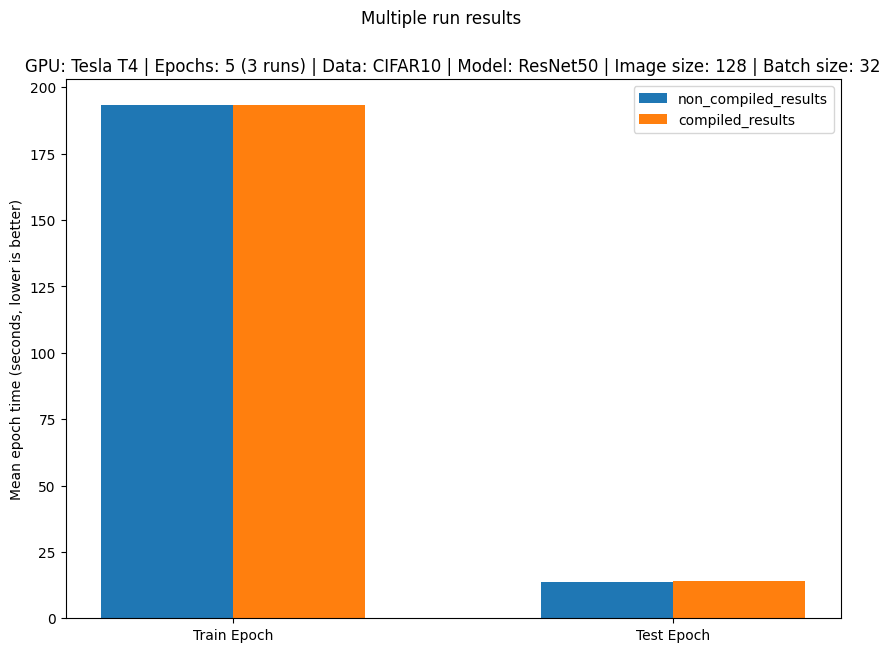

In [28]:
# Create a directory to save the multi-run figure to
os.makedirs("pytorch_2_results/figures", exist_ok=True)

# Create a path to save the figure for multiple runs
save_path_multi_run = f"pytorch_2_results/figures/multi_run_{GPU_NAME}_{MODEL_NAME}_{DATASET_NAME}_{IMAGE_SIZE}_train_epoch_time.png"

# Plot the mean epoch times for experiment 3 and 4
plot_mean_epoch_times(
    non_compiled_results = non_compile_results_multiple_runs_df,
    compiled_results = compile_results_multiple_runs_df,
    multi_runs = True,
    num_runs = NUM_RUNS,
    save_path = save_path_multi_run,
    save = True
)

In [29]:
# Make a directory for multi_run results
import os
pytorch_2_results_dir = "pytorch_2_results"
pytorch_2_multi_run_results_dir = f"{pytorch_2_results_dir}/multi_run_results"
os.makedirs(pytorch_2_multi_run_results_dir, exist_ok=True)

# Create filenames for each of the dataframes
save_name_for_multi_run_non_compiled_results = f"multi_run_non_compiled_results_{NUM_RUNS}_runs_{DATASET_NAME}_{MODEL_NAME}_{GPU_NAME}.csv"
save_name_for_multi_run_compiled_results = f"multi_run_compiled_results_{NUM_RUNS}_runs_{DATASET_NAME}_{MODEL_NAME}_{GPU_NAME}.csv"

# Create filepaths to save the results to
multi_run_no_compile_save_path = f"{pytorch_2_multi_run_results_dir}/{save_name_for_non_compiled_results}"
multi_run_compile_save_path = f"{pytorch_2_multi_run_results_dir}/{save_name_for_compiled_results}"
print(f"[INFO] Saving experiment 3 non-compiled results to: {multi_run_no_compile_save_path}")
print(f"[INFO] Saving experiment 4 compiled results to: {multi_run_compile_save_path}")

# Save the results
non_compile_results_multiple_runs_df.to_csv(multi_run_no_compile_save_path)
compile_results_multiple_runs_df.to_csv(multi_run_compile_save_path)

[INFO] Saving experiment 3 non-compiled results to: pytorch_2_results/multi_run_results/single_run_non_compiled_results_CIFAR10_ResNet50_Tesla_T4.csv
[INFO] Saving experiment 4 compiled results to: pytorch_2_results/multi_run_results/single_run_compiled_results_CIFAR10_ResNet50_Tesla_T4.csv
